In [7]:
from pulse2percept.models import BiphasicAxonMapModel, AxonMapModel, BiphasicAxonMapSpatial
from pulse2percept.implants import ArgusII
from pulse2percept.viz import scatter_correlation
import shapes

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime
import math
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score

In [8]:
data = shapes.load_shapes("../data/shapes.h5", implant='ArgusII', stim_class=['MultiElectrode', 'SpatialSummation', 'SingleElectrode'])
data.head()

,subject,amp1,amp2,area,compactness,date,eccentricity,elec_delay,electrode1,electrode2,...,image,implant,num_regions,orientation,pdur,stim_class,trial,x_center,y_center,img_shape
0,12-005,1.5,0.0,145,0.188493,20091028,0.936365,0.0,A2,,...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",ArgusII,1,0.682111,0.45,SingleElectrode,9,102.857140,147.142853,"(384, 512)"
1,12-005,1.5,0.0,174,0.165999,20091028,0.968756,0.0,A2,,...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",ArgusII,1,0.324369,0.45,SingleElectrode,17,129.333328,160.666672,"(384, 512)"
2,12-005,1.5,0.0,142,0.173824,20091028,0.871929,0.0,A2,,...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",ArgusII,1,0.594180,0.45,SingleElectrode,30,151.000000,199.000000,"(384, 512)"
3,12-005,1.5,0.0,137,0.192119,20091028,0.925959,0.0,A2,,...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",ArgusII,1,0.281614,0.45,SingleElectrode,38,256.000000,192.000000,"(384, 512)"
4,12-005,1.5,0.0,133,0.217631,20091028,0.992635,0.0,A2,,...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",ArgusII,1,0.609992,0.45,SingleElectrode,51,140.000000,218.000000,"(384, 512)"


In [9]:
data[(data['electrode1'].isin(data[(data['stim_class'] == 'SingleElectrode') & (data['num_regions'] >= 2)]['electrode1'])) & (data['stim_class'] == 'MultiElectrode')]

,subject,amp1,amp2,area,compactness,date,eccentricity,elec_delay,electrode1,electrode2,...,image,implant,num_regions,orientation,pdur,stim_class,trial,x_center,y_center,img_shape
10,12-005,1.5,1.5,434,0.783044,20091028,0.700223,0.0,A10,C10,...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",ArgusII,1,-0.150516,0.45,MultiElectrode,1,256.0,192.0,"(384, 512)"
11,12-005,1.5,1.5,595,0.536552,20091028,0.713548,0.0,A10,C10,...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",ArgusII,1,-0.760744,0.45,MultiElectrode,15,256.0,192.0,"(384, 512)"
12,12-005,1.5,1.5,459,0.465158,20091028,0.753356,0.0,A10,C10,...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",ArgusII,1,0.341745,0.45,MultiElectrode,33,256.0,192.0,"(384, 512)"
13,12-005,1.5,1.5,114,0.311651,20091028,0.927572,0.0,A10,C10,...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",ArgusII,1,0.138759,0.45,MultiElectrode,37,256.0,192.0,"(384, 512)"
14,12-005,1.5,1.5,435,0.407359,20091028,0.833744,0.0,A10,C10,...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",ArgusII,1,-0.589053,0.45,MultiElectrode,60,256.0,192.0,"(384, 512)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3427,52-001,1.5,1.5,467,0.051400,20100429,0.994058,0.0,E1,E3,...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",ArgusII,1,0.261453,0.45,MultiElectrode,6,256.0,192.0,"(384, 512)"
3428,52-001,1.5,1.5,458,0.053214,20100429,0.998363,0.0,E1,E3,...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",ArgusII,1,0.365017,0.45,MultiElectrode,14,256.0,192.0,"(384, 512)"
3429,52-001,1.5,1.5,382,0.064025,20100429,0.998385,0.0,E1,E3,...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",ArgusII,1,0.244430,0.45,MultiElectrode,22,256.0,192.0,"(384, 512)"
3430,52-001,1.5,1.5,330,0.074906,20100429,0.998768,0.0,E1,E3,...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",ArgusII,1,0.167676,0.45,MultiElectrode,31,256.0,192.0,"(384, 512)"


In [4]:
len(data[data['stim_class'] == "MultiElectrode"])

1312

In [14]:
# calculate distances
data = data[data['stim_class'].isin(["MultiElectrode", "SpatialSummation"])]
for subject in data['subject'].unique():
    implant, model = shapes.model_from_params(shapes.subject_params[subject], biphasic=False)
    locs = data['subject'] == subject
    subj_data = data.loc[locs]
    data.loc[locs,['d_retina', 'd_perp_avg', 'd_tan_avg']] = shapes.dist_perpendicular_tangential(subj_data['electrode1'].to_numpy(), subj_data['electrode2'].to_numpy(), implant, model, strategy='average')
    data.loc[locs,['d_retina', 'd_perp_up', 'd_tan_up']] = shapes.dist_perpendicular_tangential(subj_data['electrode1'].to_numpy(), subj_data['electrode2'].to_numpy(), implant, model, strategy='upstream')
    data.loc[locs,['d_retina', 'd_perp_down', 'd_tan_down']] = shapes.dist_perpendicular_tangential(subj_data['electrode1'].to_numpy(), subj_data['electrode2'].to_numpy(), implant, model, strategy='downstream')
    data.loc[locs,['d_retina', 'd_across_axonal', 'd_along_axonal']] = shapes.dist_across_along(subj_data['electrode1'].to_numpy(), subj_data['electrode2'].to_numpy(), implant, model, strategy='axonal')
    data.loc[locs,['d_retina', 'd_across_radial', 'd_along_radial']] = shapes.dist_across_along(subj_data['electrode1'].to_numpy(), subj_data['electrode2'].to_numpy(), implant, model, strategy='radial')
    data.loc[locs,['d_retina', 'd_across_mixed', 'd_along_mixed']] = shapes.dist_across_along(subj_data['electrode1'].to_numpy(), subj_data['electrode2'].to_numpy(), implant, model, strategy='mixed')
    data.loc[locs, 'same_side'] = np.sign([implant[e1].y for e1 in subj_data['electrode1']]) == np.sign([implant[e2].y for e2 in subj_data['electrode2']])


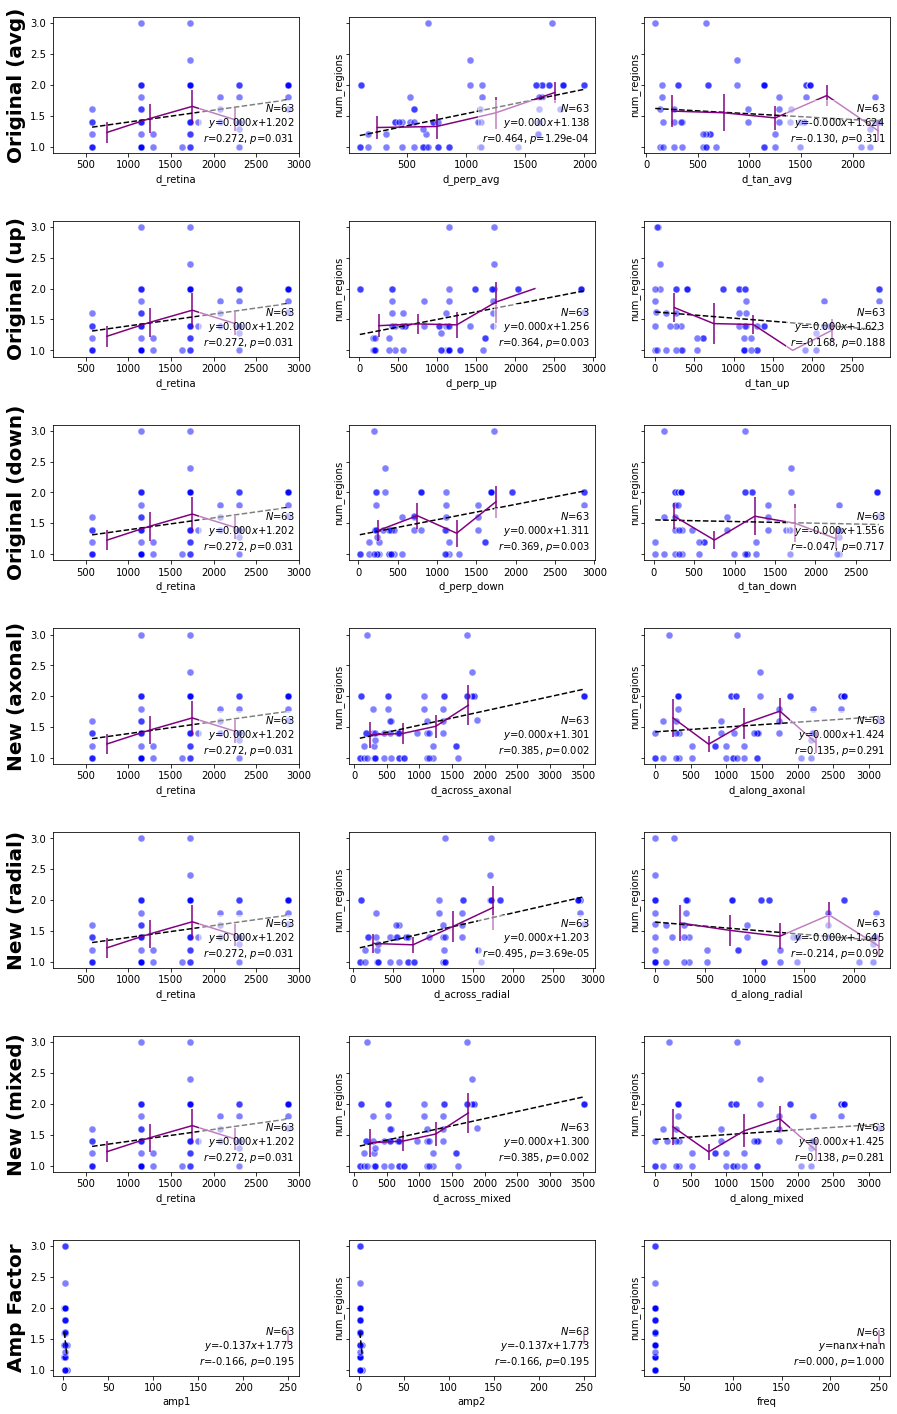

In [16]:
%matplotlib inline
cols = [['d_retina', 'd_perp_avg', 'd_tan_avg'],
        ['d_retina', 'd_perp_up', 'd_tan_up'],
        ['d_retina', 'd_perp_down', 'd_tan_down'],
        ['d_retina', 'd_across_axonal', 'd_along_axonal'],
        ['d_retina', 'd_across_radial', 'd_along_radial'],
        ['d_retina', 'd_across_mixed', 'd_along_mixed']]

rownames = ['Original (avg)', "Original (up)", "Original (down)", "New (axonal)", "New (radial)", "New (mixed)", "Amp Factor"]
data_grp = data[(data['stim_class'] == 'SpatialSummation') & (data['d_retina'] < 4000)].groupby(
    ['subject', 'electrode1', 'electrode2', 'amp1', 'amp2', 'freq'])[list(np.unique(np.concatenate(cols))) + ['num_regions']].mean().reset_index()
cols.append(['amp1', 'amp2', 'freq'])
fig, axes = plt.subplots(len(cols), len(cols[0]), figsize=(15, 25), sharey=True)
fig.subplots_adjust( hspace=0.5)
for idx, (ax_row, col) in enumerate(zip(axes, cols)):
    for i in range(len(col)): 
        binsize=500
        bins = np.arange(0, 3000, binsize)
        means = []
        stds = []
        for idx_bin in range(len(bins) - 1):
            bin_data = data_grp[(data_grp[col[i]] > bins[idx_bin]) & (data_grp[col[i]] < bins[idx_bin + 1])]
            means.append(np.mean(bin_data['num_regions']))
            stds.append(1.96 * np.std(bin_data['num_regions']) / np.sqrt(len(bin_data['num_regions'])))
        ax_row[i].errorbar(bins[:-1] + binsize/2, means, yerr=stds, color='purple')
            
        scatter_correlation(data_grp[col[i]], data_grp['num_regions'], ax=ax_row[i], show_slope_intercept=True, text_size=10 ,color='b')
        if i == 0:
            ax_row[i].set_ylabel(rownames[idx], fontweight='bold', fontsize=20)


### Same side of raphe

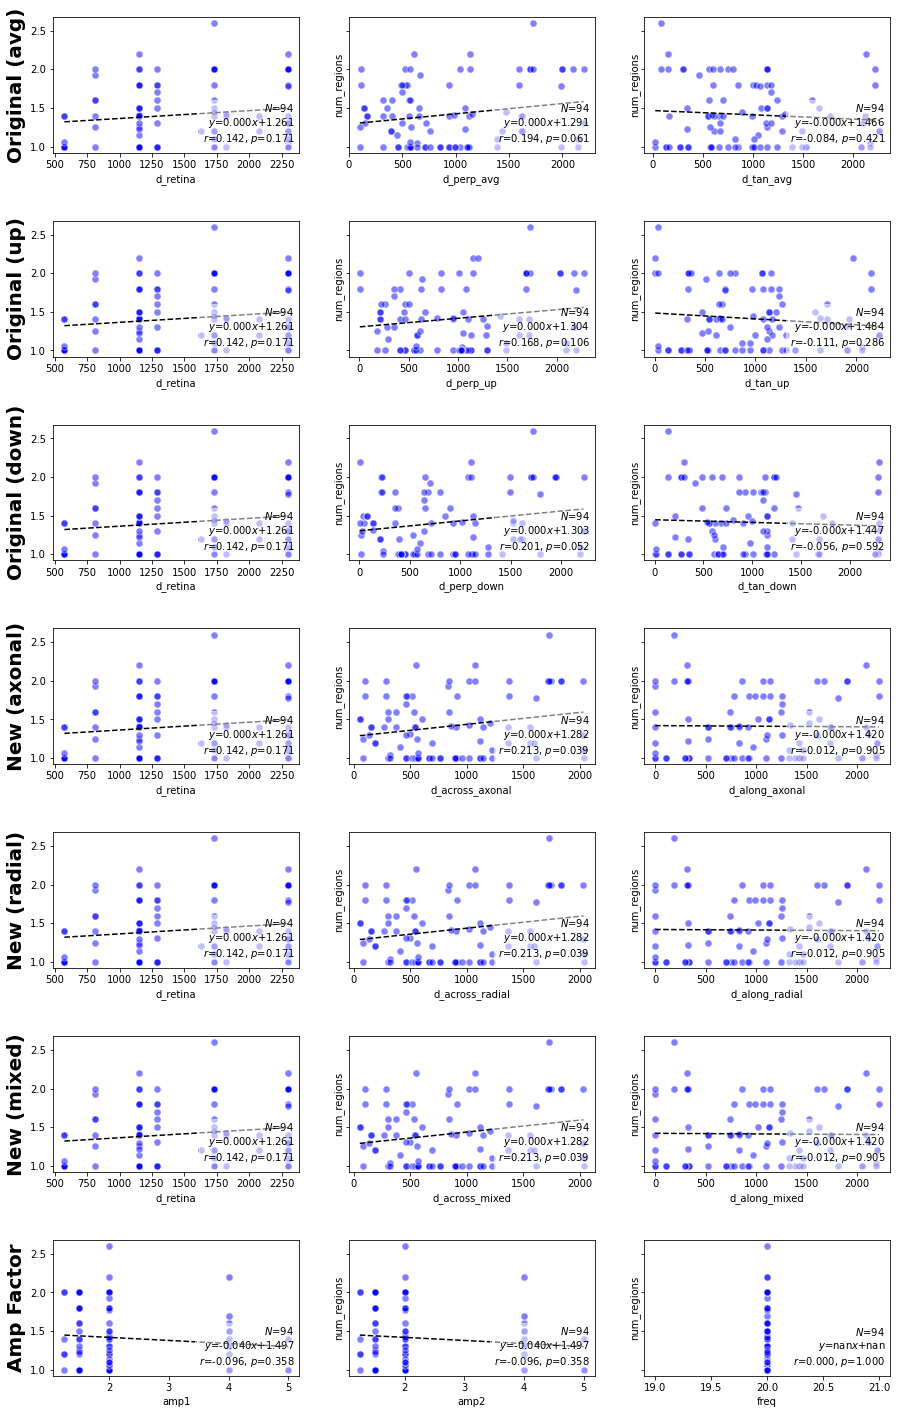

In [98]:
%matplotlib inline
cols = [['d_retina', 'd_perp_avg', 'd_tan_avg'],
        ['d_retina', 'd_perp_up', 'd_tan_up'],
        ['d_retina', 'd_perp_down', 'd_tan_down'],
        ['d_retina', 'd_across_axonal', 'd_along_axonal'],
        ['d_retina', 'd_across_radial', 'd_along_radial'],
        ['d_retina', 'd_across_mixed', 'd_along_mixed']]

rownames = ['Original (avg)', "Original (up)", "Original (down)", "New (axonal)", "New (radial)", "New (mixed)", "Amp Factor"]
data_grp = data[(data['stim_class'] == 'MultiElectrode') & (data['d_retina'] < 2500) & data['same_side'] == True].groupby(
    ['subject', 'electrode1', 'electrode2', 'amp1', 'amp2', 'freq'])[list(np.unique(np.concatenate(cols))) + ['num_regions']].mean().reset_index()
cols.append(['amp1', 'amp2', 'freq'])
fig, axes = plt.subplots(len(cols), len(cols[0]), figsize=(15, 25), sharey=True)
fig.subplots_adjust( hspace=0.5)
for idx, (ax_row, col) in enumerate(zip(axes, cols)):
    for i in range(len(col)):
        scatter_correlation(data_grp[col[i]], data_grp['num_regions'], ax=ax_row[i], show_slope_intercept=True, text_size=10 ,color='b')
        if i == 0:
            ax_row[i].set_ylabel(rownames[idx], fontweight='bold', fontsize=20)


In [32]:
data[(data['d_retina'] > 2500) & (data['num_regions'] == 1) & (data['stim_class'] == 'MultiElectrode')]

,subject,amp1,amp2,area,compactness,date,eccentricity,elec_delay,electrode1,electrode2,...,d_tan_up,d_perp_down,d_tan_down,d_across_axonal,d_along_axonal,d_across_radial,d_along_radial,d_across_mixed,d_along_mixed,same_side
166,12-005,1.5,1.5,922,0.677097,20100512,0.819240,0.0,A6,F6,...,2762.157274,2844.935112,414.691700,3515.791294,2653.625977,2805.591797,774.681152,3515.791294,2653.625977,False
181,12-005,1.5,1.5,522,0.521219,20100512,0.961207,0.0,E1,A10,...,2997.841287,5590.888106,901.440614,382.304003,8689.037109,5688.270508,0.000000,382.304003,8689.037109,False
195,12-005,2.0,2.0,1682,0.856917,20100512,0.696194,0.0,A6,F6,...,2762.157274,2844.935112,414.691700,3515.791294,2653.625977,2805.591797,774.681152,3515.791294,2653.625977,False
196,12-005,2.0,2.0,1678,0.618715,20100512,0.779142,0.0,A6,F6,...,2762.157274,2844.935112,414.691700,3515.791294,2653.625977,2805.591797,774.681152,3515.791294,2653.625977,False
573,51-009,4.0,4.0,122,0.213349,20100623,0.996054,0.0,E6,C10,...,1250.860060,2366.732388,1005.523645,1277.180556,4341.914551,2621.348877,0.000000,1277.180556,4341.914551,False
702,51-009,2.0,2.0,281,0.104654,20100526,0.997314,0.0,C5,C10,...,2374.231004,2854.626730,341.659525,546.456305,3593.628418,2888.794189,0.000000,546.456305,3593.628418,False
704,51-009,2.0,2.0,398,0.072774,20100526,0.997740,0.0,C5,C10,...,2374.231004,2854.626730,341.659525,546.456305,3593.628418,2888.794189,0.000000,546.456305,3593.628418,False
706,51-009,2.0,2.0,295,0.090765,20100526,0.995741,0.0,C5,C10,...,2374.231004,2854.626730,341.659525,546.456305,3593.628418,2888.794189,0.000000,546.456305,3593.628418,False
739,51-009,2.0,2.0,239,0.135214,20100526,0.997858,0.0,C5,C10,...,2374.231004,2854.626730,341.659525,546.456305,3593.628418,2888.794189,0.000000,546.456305,3593.628418,False
740,51-009,2.0,2.0,262,0.113779,20100526,0.997817,0.0,C5,C10,...,2374.231004,2854.626730,341.659525,546.456305,3593.628418,2888.794189,0.000000,546.456305,3593.628418,False


## Now fit psychometric curve

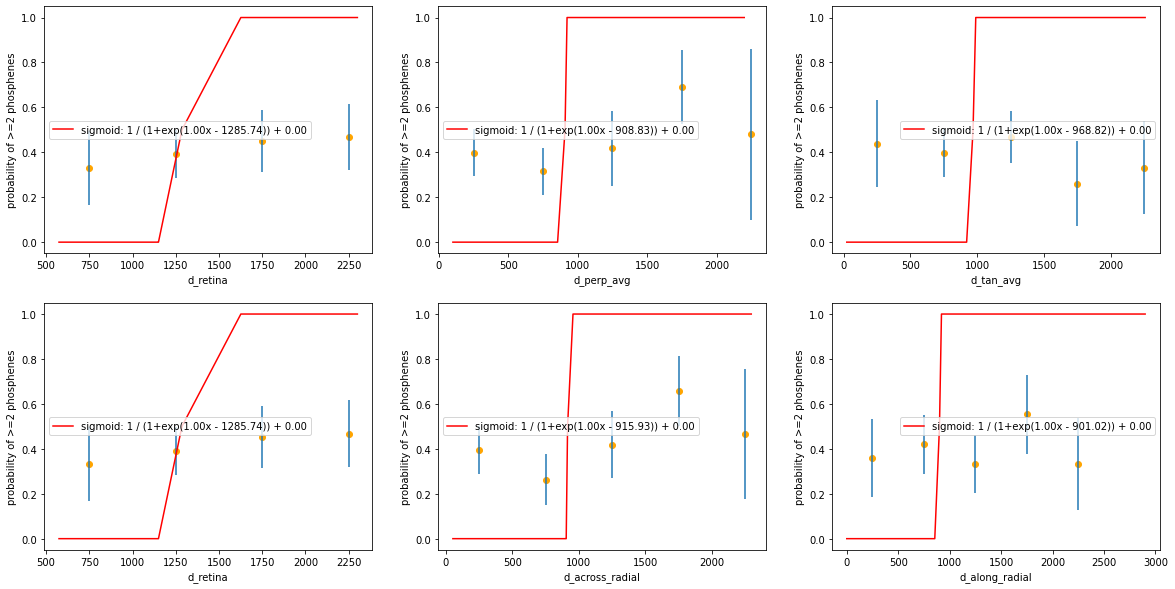

In [93]:

def sigmoid(x, x0, k, c):
    y = 1 / (1 + np.exp(-k*(x-x0)))
    return y

cols = [['d_retina', 'd_perp_avg', 'd_tan_avg'],
    ['d_retina', 'd_across_radial', 'd_along_radial']]
fig, axes = plt.subplots(len(cols), len(cols[0]), figsize=(20, 10))
agg_dict = {col : 'mean' for col in np.unique(np.concatenate(cols))}
agg_dict['num_regions'] = lambda x : np.sum(x >= 2) / len(x)
data_grp = data[(data['stim_class'] == 'MultiElectrode') & (data['d_retina'] < 2500)].groupby(
    ['subject', 'electrode1', 'electrode2','amp1'])[list(np.unique(np.concatenate(cols))) + ['num_regions']].agg(agg_dict).reset_index().rename(columns={'num_regions':'probability'})
for idx, (ax_row, col) in enumerate(zip(axes, cols)):
    for i in range(len(col)):
        
        fig.sca(ax_row[i])
        
        binsize=500
        bins = np.arange(0, 3000, binsize)
        newbins = np.copy(bins)
        means = []
        stds = []
        for idx_bin in range(len(bins) - 1):
            bin_data = data_grp[(data_grp[col[i]] > bins[idx_bin]) & (data_grp[col[i]] < bins[idx_bin + 1])]
            if len(bin_data) == 0:
                newbins = np.delete(newbins, idx_bin)
                continue
            means.append(np.mean(bin_data['probability']))
            stds.append(1.96 * np.std(bin_data['probability']) / np.sqrt(len(bin_data['probability'])))
        
        ax_row[i].errorbar(newbins[:-1] + binsize/2, means, yerr=stds, fmt='none')
        ax_row[i].scatter(newbins[:-1] + binsize/2, means, color='orange')
#         plt.scatter(data_grp[col[i]], data_grp['probability'], color='b', label='data')
        popt, pcov = curve_fit(sigmoid, newbins[:-1] + binsize/2, means, [np.median(data_grp[col[i]]),1, 0],  method='dogbox')
#         popt, pcov = curve_fit(sigmoid, data_grp[col[i]], data_grp['probability'], [np.median(data_grp[col[i]]),1, 0],  method='dogbox')
        xs = sorted(data_grp[col[i]])
        ys = [sigmoid(x, popt[0], popt[1], popt[2]) for x in xs]
        r2 = r2_score(data_grp['probability'], ys)
        plt.plot(xs, ys, color='r', label='sigmoid: 1 / (1+exp({:.2f}x - {:.2f})) + {:.2f}'.format( popt[1], popt[0], popt[2]))
        plt.xlabel(col[i])
        plt.ylabel('probability of >=2 phosphenes')
        plt.legend()

In [63]:
binsize = 500
ranges = np.arange(0, 2501, binsize)
ranges

array([   0,  500, ..., 2000, 2500])

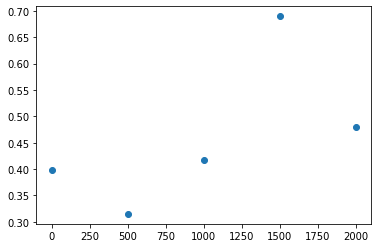

In [64]:
means = []
for i in range(len(ranges) - 1):
    df = data_grp[(data_grp['d_perp_avg'] > ranges[i]) & (data_grp['d_perp_avg'] <= ranges[i+1])]
    means.append(np.mean(df['probability']))
plt.scatter(ranges[:-1], means)

In [65]:
means

[0.39818771566597655,
 0.3150498597427477,
 0.4170127057683279,
 0.6897160005855658,
 0.48]

0